In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
mpl.use("Cairo")  # for saving SVGs that Affinity Designer can parse

import candas as can
import gumbi as gmb
from candas.test import FluorescenceData, QuantStudio

import pathlib as pl
code_pth = pl.Path.cwd()  # for running in Jupyter
# code_pth = pl.Path(__file__)  # for running in terminal
fig_pth = code_pth.parent
data_pth = fig_pth / 'data'
graph_pth = fig_pth / 'graphics'
graph_pth.mkdir(exist_ok=True)

gen_pth = fig_pth / 'generated'
gen_pth.mkdir(exist_ok=True)

plt.style.use(str(can.style.breve))

%config InlineBackend.figure_format = 'retina'

In [2]:
from utils import savefig

In [40]:
width = 5.2
height = 0.7
figsize = (width, height)
ticklabelsize = 6
labelsize = 6
titlesize = labelsize

# Set rcParams for plotting
mpl.rc("xtick", labelsize=ticklabelsize)
mpl.rc("ytick", labelsize=ticklabelsize)
mpl.rc("axes", labelsize=labelsize, titlesize=titlesize, linewidth=0.5)

mar_l = 0.11
mar_r = 0.15
mar_t = 0.5
mar_b = 2.5


def format_fig(
    fig, figsize=figsize, mar_l=mar_l, mar_r=mar_r, mar_t=mar_t, mar_b=mar_b, **kwargs
):
    """Adjust margins of subplots using figsize"""
    height, width = figsize
    fig.set_size_inches(figsize)

    plt.subplots_adjust(
        left=mar_l / width,
        right=1 - mar_r / width,
        top=1 - mar_t / height,
        bottom=mar_b / height,
        **kwargs
    )

    for ax in fig.get_axes():
        ax.tick_params(which="both", length=1.0, width=0.5)

# JG075A: EGFR Blocker Stoichiometry

In [4]:
cmax = 40

JG075A = (
    QuantStudio(data_pth / "JG075A EGFR Blocker Stoichiometry.xlsx", "JG075A")
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .normalize_reactions(cmax=cmax)
    .trim_reactions()
    #     .invert_fluorophore('HEX')
)
JG075A.reactions.wide = JG075A.reactions.wide.drop(columns=["Stage", "Derivative"])
JG075A.reactions.signal_columns = [
    col for col in JG075A.reactions.signal_columns if col != "Derivative"
]

# # Denote reaction conditions
JG075A.reactions.wide = (
    JG075A.reactions.wide.merge(
        pd.read_csv(data_pth / "JG075A Plate Map.csv")
    )  # [['Sample','WT Conc','Competitor Conc','Primer Conc']])
    .assign(lg10_Blocker=lambda df: np.log10(df["Blocker μM"]))
    .replace({"lg10_Blocker": {-np.inf: -2}})
    #     .drop(columns=['CT'])
    .query("Well != 73")  # Outlier, weird drift in baseline
)

JG075A.reactions.neaten()

/home/john/mambaforge/envs/can_manuscript/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Experiment,Well,Target,lg10_Copies,Outlier,WellPosition,Copies,Reporter,Sample,Task,Comments,CT,Reaction,Blocker,Blocker μM,WellName,lg10_Blocker,Cycle,Fluorescence,Corr_Fluorescence
0,JG075A,1,S075_WT,8.0,False,A1,100000000.0,EVAGREEN,JG075A_001,STANDARD,,56.821556,0,MMMMx,3.162278,A1,0.5,3,-0.006387,0.089428
1,JG075A,1,S075_WT,8.0,False,A1,100000000.0,EVAGREEN,JG075A_001,STANDARD,,56.821556,0,MMMMx,3.162278,A1,0.5,4,-0.005734,0.045397
2,JG075A,1,S075_WT,8.0,False,A1,100000000.0,EVAGREEN,JG075A_001,STANDARD,,56.821556,0,MMMMx,3.162278,A1,0.5,5,-0.004740,0.002104
3,JG075A,1,S075_WT,8.0,False,A1,100000000.0,EVAGREEN,JG075A_001,STANDARD,,56.821556,0,MMMMx,3.162278,A1,0.5,6,-0.001089,-0.035434
4,JG075A,1,S075_WT,8.0,False,A1,100000000.0,EVAGREEN,JG075A_001,STANDARD,,56.821556,0,MMMMx,3.162278,A1,0.5,7,0.000279,-0.077918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12235,JG075A,375,S075_SNV,1.0,False,P15,10.0,EVAGREEN,JG075A_375,STANDARD,,20.933987,238,None,0.000000,P15,-2.0,46,0.945859,1.537327
12236,JG075A,375,S075_SNV,1.0,False,P15,10.0,EVAGREEN,JG075A_375,STANDARD,,20.933987,238,None,0.000000,P15,-2.0,47,0.945898,1.524482
12237,JG075A,375,S075_SNV,1.0,False,P15,10.0,EVAGREEN,JG075A_375,STANDARD,,20.933987,238,None,0.000000,P15,-2.0,48,0.949281,1.518882
12238,JG075A,375,S075_SNV,1.0,False,P15,10.0,EVAGREEN,JG075A_375,STANDARD,,20.933987,238,None,0.000000,P15,-2.0,49,0.952237,1.512355


In [5]:
target_palette = list(zip(["S075_WT", "S075_SNV"], ["Purples", "Greens"]))
blockers = ["L-MMMMx", "MMMMx"]

In [9]:
smoothing = 0.01
threshold = 0.1


def get_CT(group, method="threshold"):
    """Interpolate and find second derivative max"""
    c = group.Cycle
    sig = group.Fluorescence
    c_ = np.linspace(c.min(), c.max(), 10000)
    spline = sp.interpolate.UnivariateSpline(c, sig, s=smoothing, k=4)

    threshold = 0.1
    crossing = -np.abs(threshold - spline(c_))
    CT = c_[np.argmax(crossing)]

    return CT


JG075A.reactions.data.drop(columns=["CT"], inplace=True)
data = JG075A.reactions.data
groupby = JG075A.reactions.metadata_columns
reaction_grps = data.groupby(groupby)
CTs = reaction_grps.apply(get_CT).rename("CT").reset_index()

JG075A.reactions.wide = JG075A.reactions.wide.merge(CTs[["Well", "CT"]])
JG075A.reactions.wide["CT"]

basal_CTs = JG075A.reactions.wide.query('Blocker == "None"').set_index(
    ["Target", "lg10_Copies"]
)["CT"]
ΔCTs = (
    (
        JG075A.reactions.wide.set_index(["Target", "lg10_Copies", "Well"])["CT"]
        - basal_CTs
    )
    .rename("ΔCT")
    .reset_index()
)
JG075A.reactions.wide = JG075A.reactions.wide.merge(ΔCTs)

In [10]:
data = JG075A.reactions.wide
data = data[(data.lg10_Copies >= 4) & (data.Blocker != "None")]

ds = gmb.DataSet(data, outputs=["ΔCT"])
gp = gmb.GP(ds).fit(
    continuous_dims=["lg10_Copies", "lg10_Blocker"],
    categorical_dims=["Blocker", "Target"],
)

/tmp/ipykernel_443326/2580486523.py:92: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


Saving fig_ED1Biii__sour_dolphin in /home/john/projects/can-manuscript/fig_ED1__shy_quokka/graphics: [.svg] [.png] done


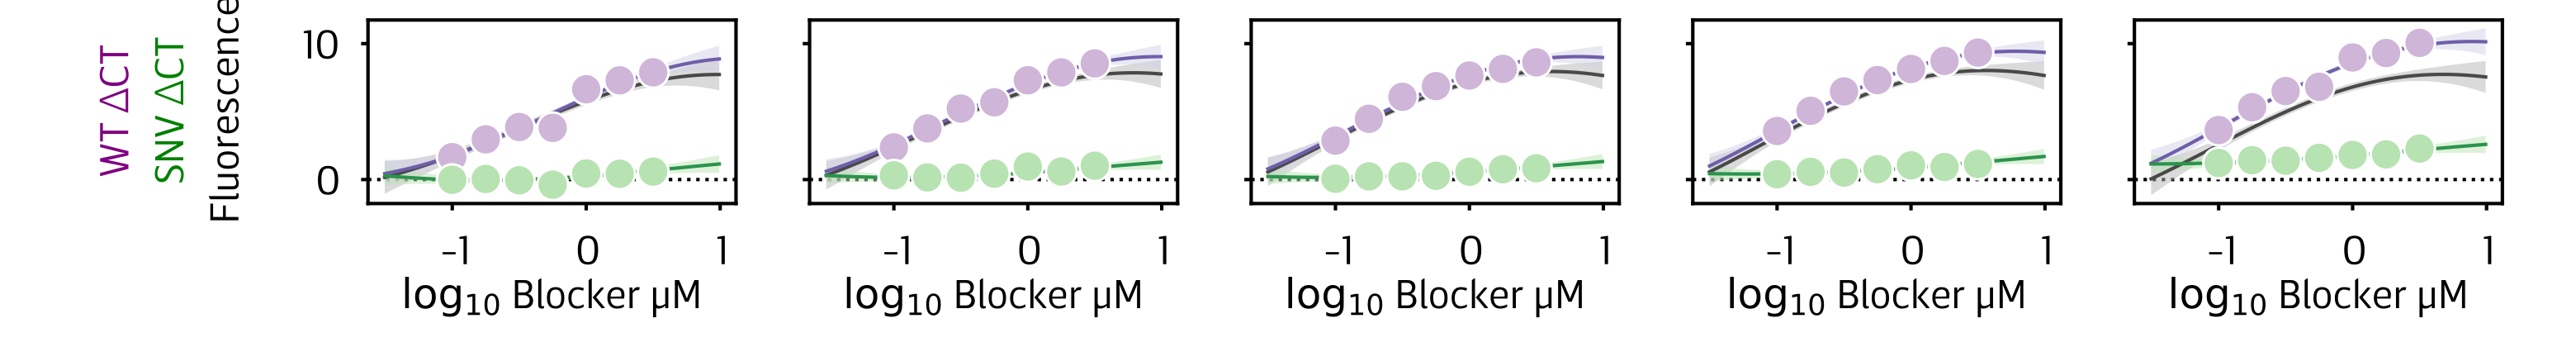

In [41]:
g = sns.relplot(
    data=data[data.Blocker == "L-MMMMx"],
    x="lg10_Blocker",
    y="ΔCT",
    col="lg10_Copies",
    # row="Blocker",
    hue="Target",
    col_order=[8.0, 7.0, 6.0, 5.0, 4.0],
    legend=False,
    palette="PRGn",
    kind="scatter",
    height=2,
    aspect=1.5,
    s=20,
    facet_kws={"margin_titles": True, "despine": False},
)

g.refline(y=0, color="k", linestyle=":", zorder=-11, linewidth=0.5)
# g.set_titles(col_template="{col_name:.2f}", row_template="{row_name}")
g.set_titles(col_template="")

for col_val, ax in g.axes_dict.items():
    at = gp.parray(lg10_Copies=col_val)
    X = gp.prepare_grid(at=at)["lg10_Blocker"]
    ΔCT_WT = gp.predict_grid(
        categorical_levels={"Target": "S075_WT", "Blocker": 'L-MMMMx'}, with_noise=False
    )
    ΔCT_SNV = gp.predict_grid(
        categorical_levels={"Target": "S075_SNV", "Blocker": 'L-MMMMx'}, with_noise=False
    )
    ΔΔCT = ΔCT_WT - ΔCT_SNV
    ΔΔCT.name = "ΔΔCT"

    plt.sca(ax)
    gmb.ParrayPlotter(x=X, y=ΔΔCT).plot(palette="binary", line_kws={'lw': 0.5})
    gmb.ParrayPlotter(x=X, y=ΔCT_WT).plot(palette="Purples", line_kws= {'lw': 0.5})
    gmb.ParrayPlotter(x=X, y=ΔCT_SNV).plot(palette="Greens", line_kws= {'lw': 0.5})

g.set(ylabel="")

fig = plt.gcf()
# multicolor_ylabel(
#     fig,
#     ("WT ΔCT", " | ", "SNV ΔCT", " | ", "ΔΔCT"),
#     ("purple", "k", "green", "k", "k"),
#     axis="y",
#     ybbox=(0, 0.2),
# )
ax = fig.axes[0]

txt_kws = dict(
    y=0.5,
    fontsize=labelsize,
    transform=ax.transAxes,
    ha="right",
    va="center",
    rotation=90,)

g.set_xlabels(r"$log_{10}$"+" Blocker μM", fontsize=labelsize, labelpad=0.5)

ax.text(
    x=-0.325,
    s='Fluorescence',
    color = "k",
    **txt_kws
)

ax.text(
    x=-0.475,
    s='SNV ΔCT',
    color = "green",
    **txt_kws
)

ax.text(
    x=-0.625,
    s='WT ΔCT',
    color = "purple",
    **txt_kws
)

format_fig(
    fig,
    figsize=(width, height),
    mar_l=0.1,
    mar_r=0.02,
    mar_t=0.3,
    mar_b=2.15,
    wspace=0.2
)

plt.tight_layout()

savefig(fig, alias="sour_dolphin")